In [24]:
''' import some cheeky modules '''

# standard modules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# %matplotlib inline
%matplotlib nbagg

# optimization module
import scipy.optimize as op

# gaussian process library by DFM
import george
from george import kernels

In [3]:
''' load and tidy data '''

# path to dataset
path = '../data/darcy_data/photometry/SN2000fa.txt' 

# open up dataset
with open(path,'r') as f: 
    content = f.readlines()

# strip the \n characters
content = [x.strip() for x in content] 

# determine length of header
for i in range(0,len(content)): 
    if content[i][0:5] == 'OBS: ':
        header_length = i
        break

# determine length of footer
for j in range(0,len(content)):
    if content[j][0:4] == 'END:':
        footer_length = len(content) - j
        break

In [4]:
# generate a structured numpy array with the relevent data
data = np.genfromtxt(path, dtype=None, skip_header=header_length, \
                     skip_footer = footer_length, \
                     names= ('VARLIST', 'MJD', 'FLT','FIELD', 'FLUXCAL', 'FLUXCALERR', \
                             'MAG', 'MAGERR')) # photometry data


In [5]:
# convert the UBVRI strings into the relevent wavelengths in nm
flt_nm = []

for i in range(0,len(data['FLT'])):
    if data['FLT'][i] == 'U':
        flt_nm.append(365.0)
    if data['FLT'][i] == 'B':
        flt_nm.append(445.0)
    if data['FLT'][i] == 'V':
        flt_nm.append(551.0)
    if data['FLT'][i] == 'R':
        flt_nm.append(658.0)
    if data['FLT'][i] == 'I':
        flt_nm.append(806.0)
    if data['FLT'][i] == 'u':
        flt_nm.append(358.0)
    if data['FLT'][i] == 'g':
        flt_nm.append(475.4)
    if data['FLT'][i] == 'r':
        flt_nm.append(620.4)
    if data['FLT'][i] == 'i':
        flt_nm.append(769.8)
    if data['FLT'][i] == 'z':
        flt_nm.append(966.5)
        
x = np.array([data['MJD'],flt_nm]).T
mjd, flt = x.T
y = np.array(data['MAG'])
yerr = np.array(data['MAGERR'])

## k0
$ k_0(r) = \theta_0^2 \delta_{ij} $

To model the noise, we include a white noise kernel. The only hyper is the amplitude of the delta function, $\theta_0$

## k1
$ k_1(r) = \theta_1(\lambda)^2\delta_{\lambda\lambda'} \, \exp \left(-\frac{r^2}{2\,\theta_2} \right) $

To model the smooth decay in time, we use a squared exponential (SE) covariance term, 
with hypers controlling the amplitude $\theta_1$, which can arbitrarily vary with wavelength, and characteristic lengthscale $\theta_2$.

In [6]:
maxy = np.array((max(y), x[np.argmax(y)][0], x[np.argmax(y)][1]))
miny = np.array((min(y), x[np.argmin(y)][0], x[np.argmin(y)][1]))
medy = np.array((np.median(y), x[np.argsort(y)[len(y)//2]][0],x[np.argsort(y)[len(y)//2]][1]) )

v1 = miny - maxy
v2 = medy - maxy

cp = np.cross(v1, v2)
a, b, c = cp

d = np.dot(cp, miny)
params = a,b,c,d

def mean_function(x):
    return (d-b*x[:,0]-c*x[:,1])/a

In [7]:
''' setup Gaussian process with initialized parameters '''

# initial hyperparameters
theta0 = [1.0, 300.0, 10.0]
print 'The initial hypers are %s' % theta0

# noise
k0 = theta0[0] * kernels.Matern32Kernel(metric=theta0[1],ndim=2,dim=1)

# SE kernel for time, with amplitude that varies with wavelength
k1 = kernels.ExpSquaredKernel(metric=theta0[2]**2,ndim=2,dim=0)

# full kernel
kernel = k0 * k1

# set up gaussian process, setting the mean as the mean of the magnitude data
gp = george.GP(kernel, mean=mean_function)

# pre-compute the factorization of the covariance matrix
gp.compute(x, yerr)

# print the initial log likelihood and gradient, using the initial hypers
print 'The initial ln likelihood is %f' % gp.lnlikelihood(y)
print 'The initial gradient with respect to the hypers is %s' % gp.grad_lnlikelihood(y)

# predict (using initial hypers)
t0x, t0y = np.meshgrid(np.linspace(min(mjd), max(mjd), 50),np.linspace(min(flt), max(flt), 50))
t0 = np.array([t0x.ravel(), t0y.ravel()]).T
mu0, cov0 = gp.predict(y, t0)
std0 = np.sqrt(np.diag(cov0))


The initial hypers are [1.0, 300.0, 10.0]
The initial ln likelihood is 46.309953
The initial gradient with respect to the hypers is [ 36.09972526   0.0698008  -22.18542416]


In [8]:
# optimize hypers

# define the objective function (negative log-likelihood in this case)
def nll(p):
    # update the kernel parameters and compute the likelihood
    gp.kernel[:] = p
    ll = gp.lnlikelihood(y, quiet=True)

    # the scipy optimizer doesn't play well with infinities
    return -ll if np.isfinite(ll) else 1e25

# the gradient of the objective function.
def grad_nll(p):
    # update the kernel parameters and compute the likelihood
    gp.kernel[:] = p
    return -gp.grad_lnlikelihood(y, quiet=True)

# run the optimization routine
p0 = gp.kernel.vector # np.log(theta[0]**2, theta[1]**2, theta[2])

results = op.minimize(nll, p0, jac=grad_nll)

# update the kernel and print the final log-likelihood and gradient
gp.kernel[:] = results.x

# theta = theta_from_x(results)
theta = [np.sqrt(np.exp(results.x[0])),np.exp(results.x[1]),np.exp(results.x[2])]
print 'The optimized hypers are %s' % theta
print 'The optimized ln likelihood is %f' % gp.lnlikelihood(y)
print 'The optimized gradient with respect to the hypers is %s' % gp.grad_lnlikelihood(y)

# predict (using final hypers)
mu, cov = gp.predict(y, t0)
std = np.sqrt(np.diag(cov))

# predict slice
t0x_slice = np.linspace(min(mjd), max(mjd), 500)
t0y_slice_445 = 445.0 * np.ones_like(t0x_slice)
t0y_slice_551 = 551.0 * np.ones_like(t0x_slice)
t0y_slice_658 = 658.0 * np.ones_like(t0x_slice)
t0y_slice_806 = 806.0 * np.ones_like(t0x_slice)

t0_slice_445 = np.array([t0x_slice, t0y_slice_445]).T
t0_slice_551 = np.array([t0x_slice, t0y_slice_551]).T
t0_slice_658 = np.array([t0x_slice, t0y_slice_658]).T
t0_slice_806 = np.array([t0x_slice, t0y_slice_806]).T

mu_slice_445, cov_slice_445 = gp.predict(y, t0_slice_445)
std_slice_445 = np.sqrt(np.diag(cov_slice_445))

mu_slice_551, cov_slice_551 = gp.predict(y, t0_slice_551)
std_slice_551 = np.sqrt(np.diag(cov_slice_551))

mu_slice_658, cov_slice_658 = gp.predict(y, t0_slice_658)
std_slice_658 = np.sqrt(np.diag(cov_slice_658))

mu_slice_806, cov_slice_806 = gp.predict(y, t0_slice_806)
std_slice_806 = np.sqrt(np.diag(cov_slice_806))

The optimized hypers are [2.3615041803063259, 1032680.1654486916, 130.88231147372815]
The optimized ln likelihood is 113.430255
The optimized gradient with respect to the hypers is [ -7.19756633e-06   1.91212180e-07   8.81836721e-06]


In [9]:
y_445=[]
yerr_445=[]
mjd_445=[]

y_551=[]
yerr_551=[]
mjd_551=[]

y_658=[]
yerr_658=[]
mjd_658=[]

y_806=[]
yerr_806=[]
mjd_806=[]

for i in range(0,len(flt)):
    if flt[i]==445.0:
        y_445.append(y[i])
        yerr_445.append(yerr[i])
        mjd_445.append(mjd[i])
    if flt[i]==551.0:
        y_551.append(y[i])
        yerr_551.append(yerr[i])
        mjd_551.append(mjd[i])
    if flt[i]==658.0:
        y_658.append(y[i])
        yerr_658.append(yerr[i])
        mjd_658.append(mjd[i])
    if flt[i]==806.0:
        y_806.append(y[i])
        yerr_806.append(yerr[i])
        mjd_806.append(mjd[i])

<IPython.core.display.Javascript object>


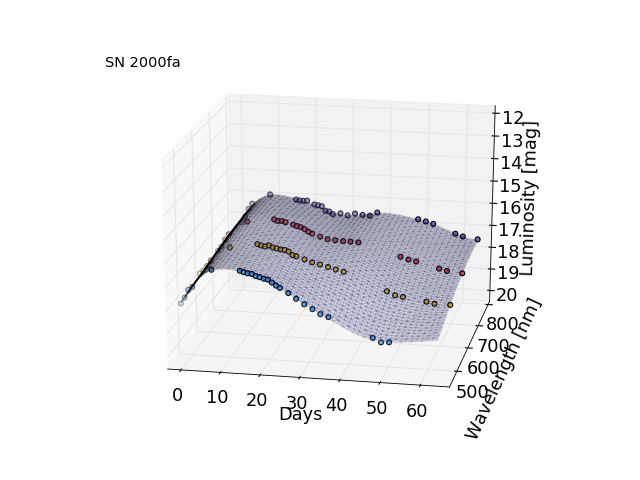

In [30]:
'''3D plot'''

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([-2,max(t0.T[0])-min(t0.T[0])+2])
ax.set_ylim([min(t0.T[1])-2,max(t0.T[1])+2])
ax.set_zlim([max(mu)+1.5,min(mu)-4.0])


ax.scatter(mjd_445-min(mjd_445), 445.0*np.ones_like(mjd_445), y_445, marker='o',c='#4D9DE0')
ax.scatter(mjd_551-min(mjd_551), 551.0*np.ones_like(mjd_551), y_551, marker='o',c='#E1BC29')
ax.scatter(mjd_658-min(mjd_658), 658.0*np.ones_like(mjd_658), y_658, marker='o',c='#E15554')
ax.scatter(mjd_806-min(mjd_806), 806.0*np.ones_like(mjd_806), y_806, marker='o',c='#7768AE')

ax.plot_trisurf(t0.T[0]-min(t0.T[0]), t0.T[1], mu,  alpha=0.1)

ax.text2D(0.05, 0.95, "SN 2000fa", transform=ax.transAxes)
ax.set_xlabel('Days')
ax.set_ylabel('Wavelength [nm]')
ax.set_zlabel('Luminosity [mag]')
plt.yticks(np.arange(500, 900, 100.0))

ax.view_init(elev=21., azim=-79.)

plt.show()
plt.savefig('surface_band_fit',dpi=300)

<IPython.core.display.Javascript object>


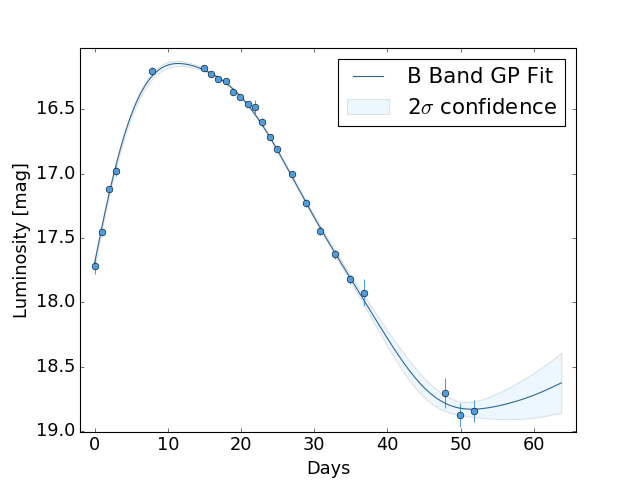

In [35]:
'''Slice plots'''
matplotlib.rcParams.update({'font.size': 16})
# optimized GP fit
fig, ax = plt.subplots(1,1)
ax.set_xlim([-2,max(t0x_slice)-min(t0x_slice)+2])
ax.set_ylim([max(mu_slice_445+std_slice_445)+0.1,min(mu_slice_445-std_slice_445)-0.1])

# ax.errorbar(t0[0:500],y,yerr=yerr, lw=0.5, ls='None', label='data')
ax.plot(t0x_slice-min(mjd_445),mu_slice_445,label='B Band GP Fit',color="#326793", alpha=1)

ax.errorbar(mjd_445-min(mjd_445), y_445,yerr_445, c='#4D9DE0',fmt="o", capsize=0)
ax.fill_between(t0x_slice-min(mjd_445), mu_slice_445+std_slice_445, mu_slice_445-std_slice_445, facecolor='#56B3FF', alpha=0.1, label = '2$\sigma$ confidence')

# plt.title('%s Band GP Fit of %s' % (band,name))
plt.legend()
plt.xlabel('Days')
plt.ylabel('Luminosity [mag]')

# #save fig
# fig_ext = 'fig/photometry_'+name+'_'+band+'band'
plt.savefig('b_band_fit',dpi=300)

plt.show()


<IPython.core.display.Javascript object>


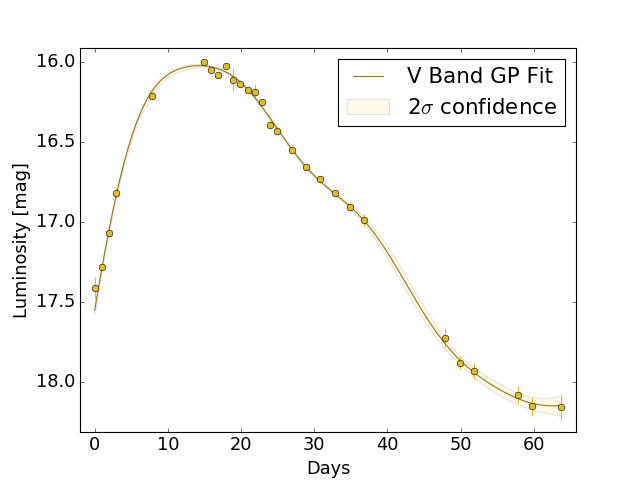

In [36]:
'''Slice plots'''
# optimized GP fit
fig, ax = plt.subplots(1,1)
ax.set_xlim([-2,max(t0x_slice)-min(t0x_slice)+2])
ax.set_ylim([max(mu_slice_551+std_slice_551)+0.1,min(mu_slice_551-std_slice_551)-0.1])

# ax.errorbar(t0[0:500],y,yerr=yerr, lw=0.5, ls='None', label='data')
ax.plot(t0x_slice-min(mjd_551),mu_slice_551,label='V Band GP Fit',color="#937B1A", alpha=1)

ax.errorbar(mjd_551-min(mjd_551), y_551,yerr_551, c='#E1BC29',fmt="o", capsize=0)
ax.fill_between(t0x_slice-min(mjd_551), mu_slice_551+std_slice_551, mu_slice_551-std_slice_551, facecolor='#FFD52D', alpha=0.1, label = '2$\sigma$ confidence')

# plt.title('%s Band GP Fit of %s' % (band,name))
plt.legend()
plt.xlabel('Days')
plt.ylabel('Luminosity [mag]')

# #save fig
# fig_ext = 'fig/photometry_'+name+'_'+band+'band'
plt.savefig('v_band_fit',dpi=300)

plt.show()

<IPython.core.display.Javascript object>


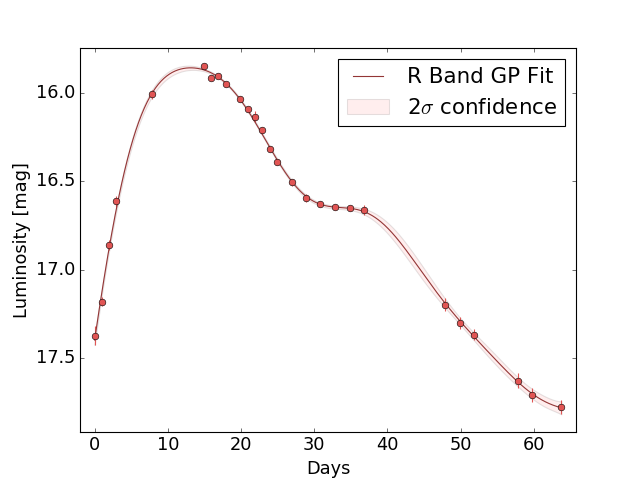

In [37]:
'''Slice plots'''
# optimized GP fit
fig, ax = plt.subplots(1,1)
ax.set_xlim([-2,max(t0x_slice)-min(t0x_slice)+2])
ax.set_ylim([max(mu_slice_658+std_slice_658)+0.1,min(mu_slice_658-std_slice_658)-0.1])

# ax.errorbar(t0[0:500],y,yerr=yerr, lw=0.5, ls='None', label='data')
ax.plot(t0x_slice-min(mjd_658),mu_slice_658,label='R Band GP Fit',color="#933636", alpha=1)

ax.errorbar(mjd_658-min(mjd_658), y_658,yerr_658, c='#E15554',fmt="o", capsize=0)
ax.fill_between(t0x_slice-min(mjd_658), mu_slice_658+std_slice_658, mu_slice_658-std_slice_658, facecolor='#FF5E5E', alpha=0.1, label = '2$\sigma$ confidence')

# plt.title('%s Band GP Fit of %s' % (band,name))
plt.legend()
plt.xlabel('Days')
plt.ylabel('Luminosity [mag]')

# #save fig
# fig_ext = 'fig/photometry_'+name+'_'+band+'band'
plt.savefig('r_band_fit',dpi=300)

plt.show()

<IPython.core.display.Javascript object>


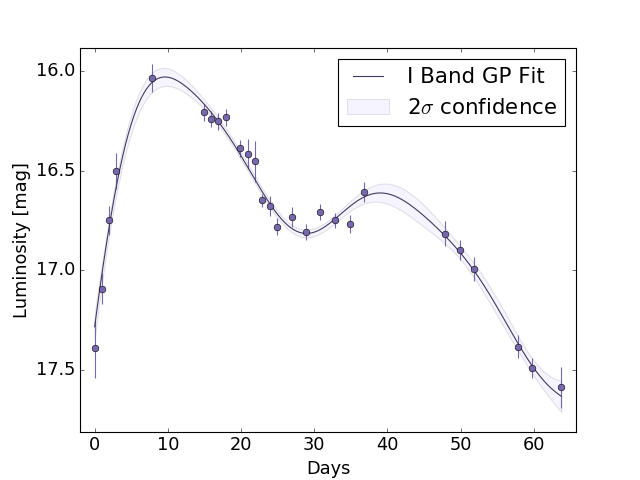

In [38]:
'''Slice plots'''
# optimized GP fit
fig, ax = plt.subplots(1,1)
ax.set_xlim([-2,max(t0x_slice)-min(t0x_slice)+2])
ax.set_ylim([max(mu_slice_806+std_slice_806)+0.1,min(mu_slice_806-std_slice_806)-0.1])

# ax.errorbar(t0[0:500],y,yerr=yerr, lw=0.5, ls='None', label='data')
ax.plot(t0x_slice-min(mjd_806),mu_slice_806,label='I Band GP Fit',color="#423A60", alpha=1)

ax.errorbar(mjd_806-min(mjd_806), y_806,yerr_806, c='#7768AE',fmt="o", capsize=0)
ax.fill_between(t0x_slice-min(mjd_806), mu_slice_806+std_slice_806, mu_slice_806-std_slice_806, facecolor='#AF99FF', alpha=0.1, label = '2$\sigma$ confidence')

# plt.title('%s Band GP Fit of %s' % (band,name))
plt.legend()
plt.xlabel('Days')
plt.ylabel('Luminosity [mag]')

# #save fig
# fig_ext = 'fig/photometry_'+name+'_'+band+'band'
plt.savefig('i_band_fit',dpi=300)

plt.show()